<a href="https://colab.research.google.com/github/ansar2019/image-captionig/blob/main/kosmos_2_Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git accelerate bitsandbytes

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 9.1 MB/s eta 0:00:00


In [2]:
from transformers import AutoProcessor, AutoModelForVision2Seq

processor = AutoProcessor.from_pretrained("microsoft/kosmos-2-patch14-224")
model = AutoModelForVision2Seq.from_pretrained("microsoft/kosmos-2-patch14-224", load_in_4bit=True, device_map={"": 0})

preprocessor_config.json:   0%|          | 0.00/534 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/191k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.70M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/32.0k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/4.45k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.66G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

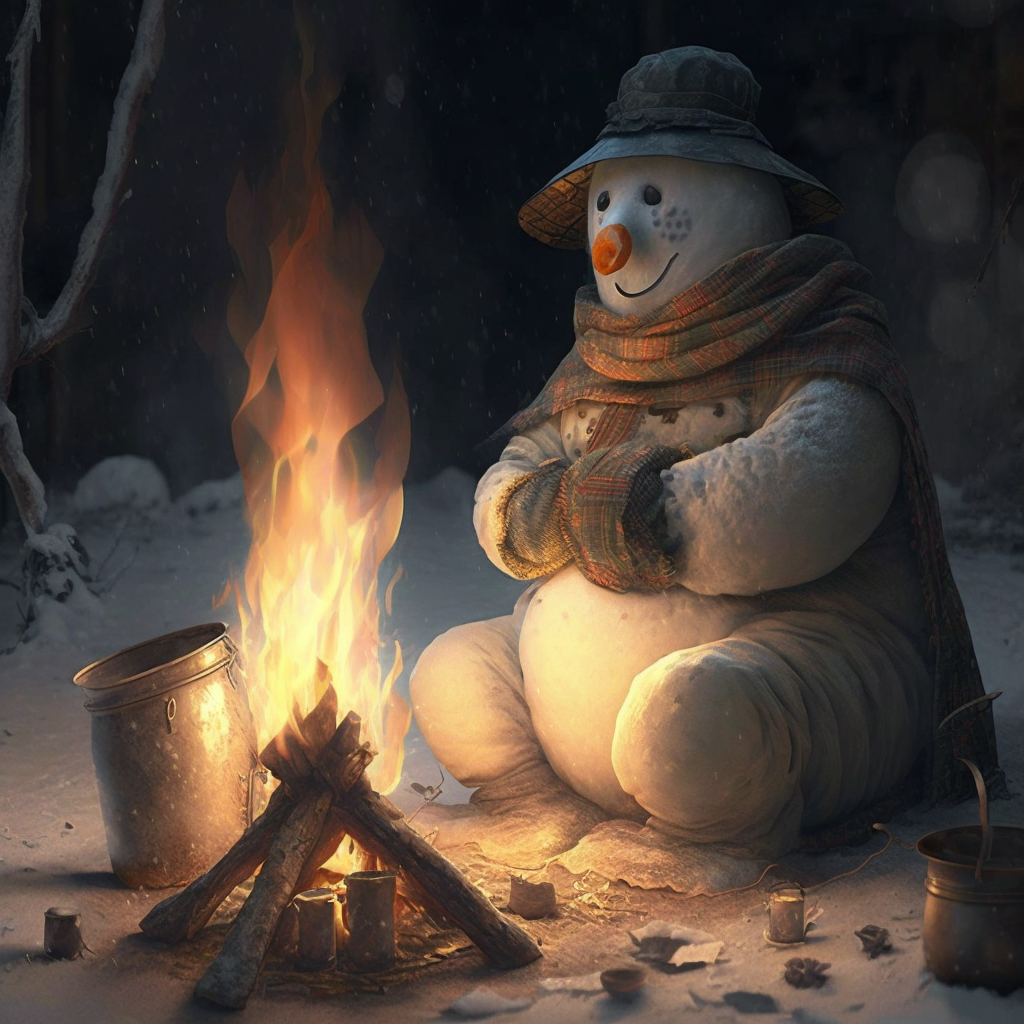

In [3]:
import requests
from PIL import Image

prompt = "<grounding>An image of"
url = "https://huggingface.co/microsoft/kosmos-2-patch14-224/resolve/main/snowman.png"
image = Image.open(requests.get(url, stream=True).raw)
image

In [4]:
inputs = processor(text=prompt, images=image, return_tensors="pt").to("cuda:0")

# Autoregressively generate completion
generated_ids = model.generate(**inputs, max_new_tokens=128)
# Convert generated token IDs back to strings
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

/usr/local/lib/python3.10/dist-packages/bitsandbytes/nn/modules.py:226: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_type=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(f'Input type into Linear4bit is torch.float16, but bnb_4bit_compute_type=torch.float32 (default). This will lead to slow inference or training speed.')


In [5]:
print(generated_text)

<image>. the, to and of as in I that' for is was- on’ it with The as at bet he have from by are " you his “ this said not has an ( but had we her they will my or were their): up about out who one all been she can more would It</image><grounding> An image of<phrase> a snowman</phrase><object><patch_index_0044><patch_index_0863></object> warming up by<phrase> a fire</phrase><object><patch_index_0006><patch_index_0879></object>


In [6]:
# By default, the generated text is cleaned up and the entities are extracted.
processed_text, entities = processor.post_process_generation(generated_text)

print(processed_text)
print(entities)

An image of a snowman warming up by a fire
[('a snowman', (12, 21), [(0.390625, 0.046875, 0.984375, 0.828125)]), ('a fire', (36, 42), [(0.203125, 0.015625, 0.484375, 0.859375)])]


In [7]:
end_of_image_token = processor.eoi_token
caption = generated_text.split(end_of_image_token)[-1]
print(caption)

<grounding> An image of<phrase> a snowman</phrase><object><patch_index_0044><patch_index_0863></object> warming up by<phrase> a fire</phrase><object><patch_index_0006><patch_index_0879></object>


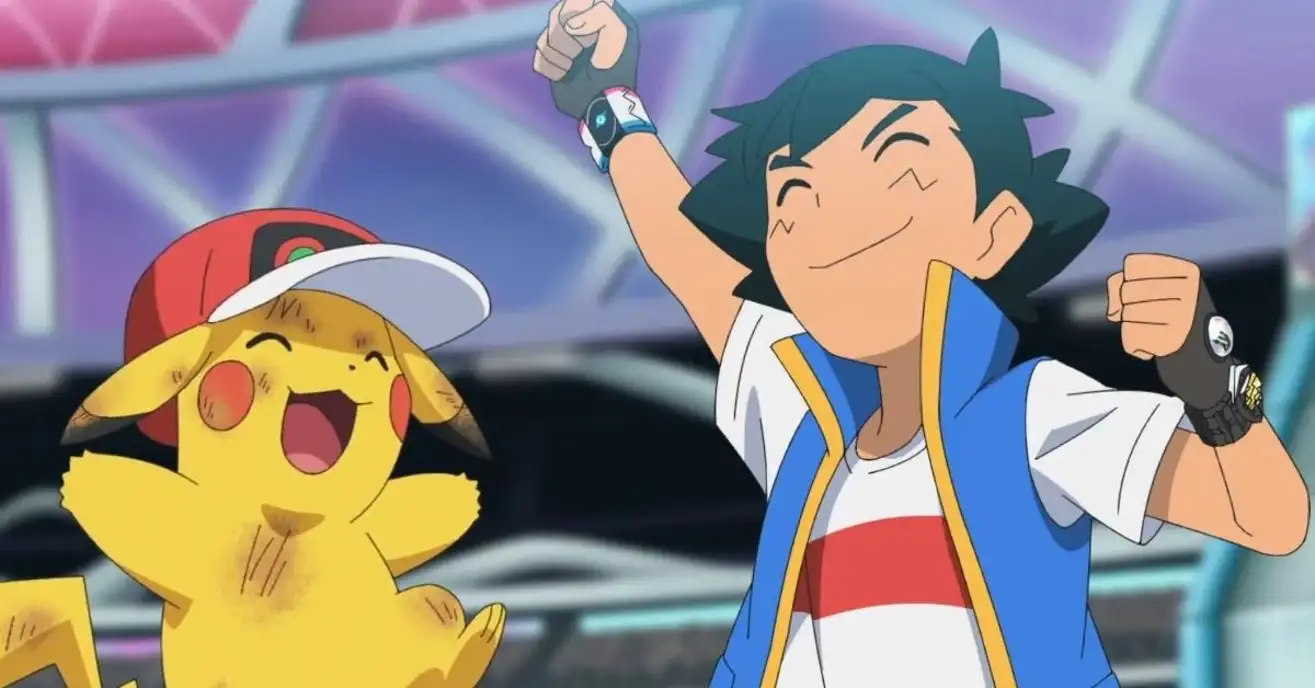

In [10]:
import requests
from PIL import Image

prompt = "<grounding>An image of"
url =  "https://huggingface.co/ydshieh/kosmos-2-patch14-224/resolve/main/pikachu.png"
image = Image.open(requests.get(url, stream=True).raw)
image

In [11]:
inputs = processor(text=prompt, images=image, return_tensors="pt").to("cuda:0")

# Autoregressively generate completion
generated_ids = model.generate(**inputs, max_new_tokens=128)
# Convert generated token IDs back to strings
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

<image>. the, to and of as in I that' for is was- on’ it with The as at bet he have from by are " you his “ this said not has an ( but had we her they will my or were their): up about out who one all been she can more would It</image><grounding> An image of<phrase> Pikachu</phrase><object><patch_index_0012><patch_index_1023></object> and<phrase> Ash</phrase><object><patch_index_0288><patch_index_1004></object>,<phrase> the main protagonists of the Pokémon anime</phrase><object><patch_index_0013><patch_index_1023></object>, cheering in the foreground


In [12]:
# By default, the generated text is cleaned up and the entities are extracted.
processed_text, entities = processor.post_process_generation(generated_text)

print(processed_text)
print(entities)
end_of_image_token = processor.eoi_token
caption = generated_text.split(end_of_image_token)[-1]
print(caption)

An image of Pikachu and Ash, the main protagonists of the Pokémon anime, cheering in the foreground
[('Pikachu', (12, 19), [(0.390625, 0.015625, 0.984375, 0.984375)]), ('Ash', (24, 27), [(0.015625, 0.296875, 0.390625, 0.984375)]), ('the main protagonists of the Pokémon anime', (29, 71), [(0.421875, 0.015625, 0.984375, 0.984375)])]
<grounding> An image of<phrase> Pikachu</phrase><object><patch_index_0012><patch_index_1023></object> and<phrase> Ash</phrase><object><patch_index_0288><patch_index_1004></object>,<phrase> the main protagonists of the Pokémon anime</phrase><object><patch_index_0013><patch_index_1023></object>, cheering in the foreground


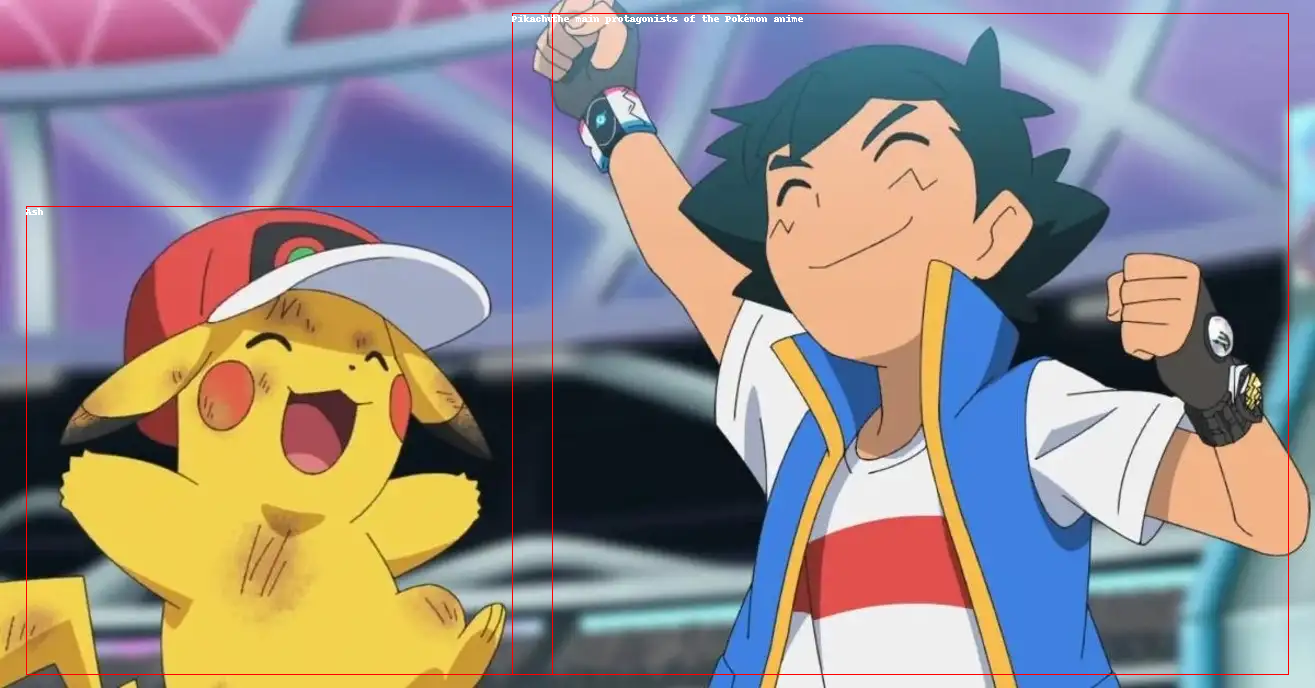

In [13]:
from PIL import ImageDraw

width, height = image.size
draw = ImageDraw.Draw(image)

for entity, _, box in entities:
    box = [round(i, 2) for i in box[0]]
    x1, y1, x2, y2 = tuple(box)
    x1, x2 = x1 * width, x2 * width
    y1, y2 = y1 * height, y2 * height
    draw.rectangle(xy=((x1, y1), (x2, y2)), outline="red")
    draw.text(xy=(x1, y1), text=entity)

image

In [8]:
from google.colab import drive
drive.mount('/content/Drive')

Mounted at /content/Drive


In [9]:
import glob
filenames = glob.glob("/content/Drive/MyDrive/testdata/*.jpg")
filenames.sort()
for image in filenames:
 prompt = "<grounding>An image of"
 raw_image = Image.open(image)
 inputs = processor(text=prompt, images=raw_image, return_tensors="pt").to("cuda:0")
 generated_ids = model.generate(**inputs, max_new_tokens=128)
 generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
 processed_text = processor.post_process_generation(generated_text, cleanup_and_extract=False)
 print(processed_text)
 processed_text, entities = processor.post_process_generation(generated_text)
 print(image,processed_text)
 with open('kosmos-2.txt', 'a') as fp:
  fp.write(str([image])+str([processed_text]))
  fp.write('\n')
#print(entities)


<grounding> An image of<phrase> two men</phrase><object><patch_index_0130><patch_index_0908></delimiter_of_multi_objects/><patch_index_0112><patch_index_0892></object> standing at<phrase> a podium</phrase><object><patch_index_0356><patch_index_0982></object>, one of them speaking.
/content/Drive/MyDrive/testdata/File 001.jpg An image of two men standing at a podium, one of them speaking.
<grounding> An image of<phrase> children</phrase><object><patch_index_0141><patch_index_1018></delimiter_of_multi_objects/><patch_index_0132><patch_index_0976></delimiter_of_multi_objects/><patch_index_0116><patch_index_1023></delimiter_of_multi_objects/><patch_index_0128><patch_index_0839></object> sitting at<phrase> a table</phrase><object><patch_index_0003><patch_index_0208></object> in a classroom
/content/Drive/MyDrive/testdata/File 002.jpg An image of children sitting at a table in a classroom
<grounding> An image of<phrase> three women</phrase><object><patch_index_0202><patch_index_0723></delimi